In [2]:
import pandas as pd
import networkx as nx
from pyspark import SparkContext
import time
import numpy as np
import gdown
import os

In [2]:
from platform import python_version
print(python_version())
import sys
print(sys.path)

3.7.6
['/global/cscratch1/sd/cchen67/CS526/Project_Gu_Chen', '', '/opt/mods/lib/python3.6/site-packages', '/opt/ovis/lib/python3.6/site-packages', '/global/homes/c/cchen67/OpenEye-toolkits-python3-linux-x64-2019.10.2', '/global/homes/c/cchen67/anaconda3/lib/python37.zip', '/global/homes/c/cchen67/anaconda3/lib/python3.7', '/global/homes/c/cchen67/anaconda3/lib/python3.7/lib-dynload', '/global/homes/c/cchen67/.local/lib/python3.7/site-packages', '/global/homes/c/cchen67/anaconda3/lib/python3.7/site-packages', '/global/homes/c/cchen67/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/global/u1/c/cchen67/.ipython']


In [4]:
fdownload = {
"large.clique" : "https://drive.google.com/file/d/1BKjc9we7qCoJ5lFAoY5DCYXxbZIrNG4A/view?usp=sharing",
"middle.clique" : "https://drive.google.com/file/d/1i24rvEufCwibeDh9RzqUEigZHxSv4KcG/view?usp=sharing",
"small.clique" : "https://drive.google.com/file/d/1phbG6V8Mx2Dk30rfAL2gI0xYCZIYhlHc/view?usp=sharing",
"C14.280.edgelist": "https://drive.google.com/file/d/1p7wPv4CxtGJ9y8GQ7kXsNpM89xxwbpPE/view?usp=sharing",
"C14-280-cliques.clique": "https://drive.google.com/file/d/1OZTfCtZpvNXvQjEpWjZjNhCm01eqbBSd/view?usp=sharing"}

In [4]:
for output, url in fdownload.items():
    gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1BKjc9we7qCoJ5lFAoY5DCYXxbZIrNG4A
To: /global/cscratch1/sd/cchen67/CS526/Project_Gu_Chen/large.clique
100%|██████████| 42.0M/42.0M [00:03<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i24rvEufCwibeDh9RzqUEigZHxSv4KcG
To: /global/cscratch1/sd/cchen67/CS526/Project_Gu_Chen/middle.clique
100%|██████████| 20.8M/20.8M [00:03<00:00, 5.96MB/s]
Downloading...
From: https://drive.google.com/uc?id=1phbG6V8Mx2Dk30rfAL2gI0xYCZIYhlHc
To: /global/cscratch1/sd/cchen67/CS526/Project_Gu_Chen/small.clique
100%|██████████| 21.4M/21.4M [00:01<00:00, 12.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p7wPv4CxtGJ9y8GQ7kXsNpM89xxwbpPE
To: /global/cscratch1/sd/cchen67/CS526/Project_Gu_Chen/C14.280.edgelist
100%|██████████| 38.6M/38.6M [00:02<00:00, 13.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OZTfCtZpvNXvQjEpWjZjNhCm01eqbBSd
To: /global/cscratch1/sd/cchen67/CS526/Project_Gu_Chen/C14-280-cliques.clique
100

In [5]:
graphfile = "C14.280.edgelist"
graph = pd.read_csv(graphfile, header = None)
graph = graph.iloc[1: , :]
graph = graph[0].str.split(expand=True)
graph = nx.from_pandas_edgelist(graph, source = 0, target = 1)

In [6]:
inputfile = "C14-280-cliques.clique"
cliques = pd.read_csv(inputfile, header = None, names = ["cliques"])
cliques.reset_index(drop = False, inplace = True)

In [7]:
cliques["len"] = cliques["cliques"].apply(lambda x : len(x.strip().split("\t")))

In [8]:
print(len(cliques.loc[cliques["len"] < 100, "cliques"]))
print(len(cliques.loc[(cliques["len"] >= 100) & (cliques["len"] < 250), "cliques"]))
print(len(cliques.loc[cliques["len"] >= 250, "cliques"]))

62882
17707
9222


In [9]:
cliques.loc[cliques["len"] < 100, "cliques"].to_csv("small.clique", index = False, header = False)
cliques.loc[(cliques["len"] >= 100) & (cliques["len"] < 250), "cliques"].to_csv("middle.clique", index = False, header = False)
cliques.loc[cliques["len"] >= 250, "cliques"].to_csv("large.clique", index = False, header = False)

### Distribution of clique size

[]

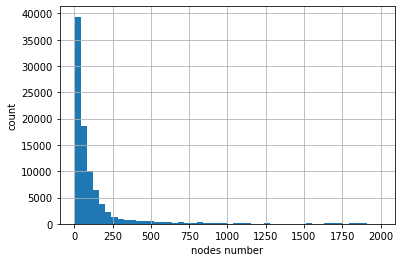

In [10]:
hist = cliques["len"].hist(bins = 50)
hist.set_xlabel("nodes number")
hist.set_ylabel("count")
hist.plot()

###  WithoutMR
sequentially apply Para-clique on each clique

In [11]:
def para_clique_NMR(clique, sep, G, glom):
    """
    Input clique: one clique
          sep: sepration in clique list, in our case, sep = '\t'
          G: edgelist
          glom: parameter to limit para-clique
    Output res_edges: imputed edges list of clique
    """
    # seperate clique list into list of clique nodes
    cnodes = set(clique.strip().split(sep))
    len_cnodes = len(cnodes)
    neibors = {}
    # find neighbors (neighbors that are connect to clique nodes)
    for cnode in cnodes:
        cnode_neibors = set(G.neighbors(cnode)) - cnodes
        for cneibor in cnode_neibors:
            if cneibor not in neibors.keys():
                neibors[cneibor] = 0
            neibors[cneibor] = neibors[cneibor] + 1
    
    # filter out the neighbors (those lose larger than glom connections)
    neibors = dict(filter(lambda x: x[1] + glom >= len_cnodes, neibors.items()))
    res_edges = []
    # find the impute nodes for neighbors 
    for impute_node, glom_num in neibors.items():
        impute_clique_nodes = cnodes - set(G.neighbors(impute_node))
        for clique_node in impute_clique_nodes:
            res_edges.append((impute_node, clique_node))
    return res_edges


def paraclique1(cliques, sep, graph, glom):
    impute_edge = []
    cliques["res"] = cliques["cliques"].apply(para_clique_NMR, args = (sep, graph, glom))
    for i in cliques.index:
        impute_edge.extend(cliques.loc[i, "res"])
    return impute_edge

###  ForMR
ForMR: applied for loop and MapReduce to parallel compute the clique set, and the process of each individual clique is the same with WithoutMR

In [12]:
def para_clique_FMR(clique, sep, G, glom):
    """
    The same code with para_clique_NMR
    Input clique: one clique
          sep: sepration in clique list, in our case, sep = '\t'
          G: edgelist
          glom: parameter to limit para-clique
    Output res_edges: imputed edges list of clique
    """
    cnodes = set(clique.strip().split(sep))
    len_cnodes = len(cnodes)
    neibors = {}
    neibors_source = {}
    # find all the neibors for all the nodes in the clique
    for cnode in cnodes:
        cnode_neibors = set(G.neighbors(cnode))
        cnode_neibors = cnode_neibors - cnodes
        for cneibor in cnode_neibors:
            if cneibor not in neibors.keys():
                neibors[cneibor] = 0
                neibors_source[cneibor] = set([])
            neibors[cneibor] = neibors[cneibor] + 1
            neibors_source[cneibor].add(cnode)
    res = []
    for node, num in neibors.items():
        if num + glom >= len_cnodes:
            res.append( (node, len_cnodes - num) )
    #res_edges = set([])
    res_edges = []
    for impute_node, glom_num in res:
        impute_clique_nodes = cnodes - neibors_source[impute_node]
        for clique_node in impute_clique_nodes:
            res_edges.append((impute_node, clique_node))
    return res_edges


def paraclique2(sc, cliques, sep, graph, glom):
    cliques = sc.parallelize(cliques.values)
    impute_edges = cliques.flatMap(lambda x: para_clique_FMR(x[0], sep, graph, glom))
    impute_edges = impute_edges.collect()
    return impute_edges

### MR: 
transform cliques rdd to clique nodes rdd and applying Para-clique on every single nodes parallel.

In [13]:
def cliques_tonode(clique, sep):
    ID = [clique[0]] * len(clique[1])
    return list(zip(ID, clique[1]))
def process_node(clique_id, cnode, cnodes, G):
    cnode_neibors = set(G.neighbors(cnode))
    cnode_neibors = cnode_neibors - cnodes
    neibors = []
    for cneibor in cnode_neibors:
        neibors.append(((clique_id, cneibor), 1))
    return neibors
def add(x, y):
    return x + y
def process_neibor(cnodes, cneibor, G):
    miss_nodes = cnodes - set(G.neighbors(cneibor))
    neibors = [cneibor] * len(miss_nodes)
    return list(zip(miss_nodes, neibors))
def process_df(sc, df, sep, glom, G):
    """
    The same code with para_clique_NMR
    Input sc: SparkContext
          df: all cliques
          sep: sepration in clique list, in our case, sep = '\t'
          glom: parameter to limit para-clique
          G: edgelist
    Output res_edges: imputed edges list of clique
    """
    rdd =  sc.parallelize(df.values)
    rdd = rdd.map(lambda x : (x[0], set(x[1].strip().split(sep))))
    rddmap = rdd.collectAsMap()
    #[(ID, clique_node)]
    rdd = rdd.flatMap(lambda x : cliques_tonode(x, sep))
    #[((ID, cneibor), 1)]
    rdd = rdd.flatMap(lambda x : process_node(x[0], x[1], rddmap[x[0]], G))
    cneibor_count = rdd.reduceByKey(add)
    #[(ID, cneibor, miss_count)]
    cneibor_count = cneibor_count.map(lambda x : (x[0][0], x[0][1], len(rddmap[x[0][0]]) - x[1]))
    cneibor_count = cneibor_count.filter(lambda x: x[2] <= glom)
    impute_edges = cneibor_count.flatMap(lambda x : process_neibor(rddmap[x[0]], x[1], G))
    return impute_edges.collect()


def paraclique3(sc, cliques, sep, graph, glom):
    cliques.reset_index(drop = False, inplace = True)
    impute_edges = process_df(sc, cliques, sep, glom, graph)
    return impute_edges

In [14]:
smallclique = "small.clique"
middleclique = "middle.clique"
largeclique = "large.clique"

In [15]:
sc = SparkContext.getOrCreate()

### Initial setting
* glom:  is a parameter that limit the Para-clique. Para-clique is at most not connect to clique with glom nodes.
* samplesize: the number of cliques in each sample dataset
* samplenum: number of sample dataset we run, for our results, we have ran 10 sample datasets for each job.
* inputfile: can be smallclique, middleclique and largeclique

In [16]:
sep = "\t"
glom = 1
samplesize = 5
samplenum = 1
inputfile = smallclique
runtime = pd.DataFrame(columns = ["WithoutMR", "ForMR", "MR"])
cliquesdata = pd.read_csv(inputfile, header = None, names = ["cliques"])

In [ ]:
for i in range(samplenum):
    cliques = cliquesdata.sample(samplesize)
   
    start = time.time()
    res1 = paraclique1(cliques, sep, graph, glom)
    end = time.time()
    #pd.DataFrame(res1).to_csv(inputfile.split('.')[0] + ".res1", index = False, header = False)
    WithoutMR = end - start
    print(len(res1))
    start = time.time()
    res2 = paraclique2(sc, cliques, sep, graph, glom)
    end = time.time()
    print(len(res2))
    #pd.DataFrame(res2).to_csv(inputfile.split('.')[0] + ".res2", index = False, header = False)
    ForMR = end - start
    start = time.time()
    res3 = paraclique3(sc, cliques, sep, graph, glom)
    end = time.time()
    print(len(res3))
    #pd.DataFrame(res3).to_csv(inputfile.split('.')[0] + ".res3", index = False, header = False)
    MR = end - start
    tmp = pd.DataFrame([[WithoutMR, ForMR, MR]], columns = ["WithoutMR", "ForMR", "MR"])
    runtime = pd.concat([runtime, tmp])
# runtime.to_csv(inputfile.split('.')[0] + str(samplesize) + "-" + str(samplenum) + ".time", index = False)

1096


In [ ]:
runtime

In [5]:
for output in fdownload.keys():
    os.system("rm " + output)

#### We can see that the length of each results are the same, we can say that all three algorithms works. And the runtime is shown above. For more running time results, please check time\time_resluts_plot.ipynb which contains visualization of the time tables.